# Import Libraries

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from PIL import Image

import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import random
import torch
import keras
from tensorflow.keras.metrics import MeanIoU
import requests
import pickle
import re
import os
import cv2

Segmentation Models: using `keras` framework.


# Define Input directories

In [11]:
#these codes are used to loop through the directory
path_images = 'rs19_val/jpgs/rs19_val/'
path_images_resized = 'rs19_val/960_512/images_resized/'
path_masks = 'rs19_val/uint8/rs19_val/'
path_masks_resized_track = 'rs19_val/960_512/masks_resized_track/'
path_masks_resized_veg ='rs19_val/mask_veg_resized_512_960/'


# read the tram list and turn it into a dict
tram_list = pd.read_csv('tram_filenames.csv')
tram_dict = tram_list.iloc[:,1:].to_dict()

# Define Labels

In [8]:
# pixel labels for each class
tram_track=3 
rail_track=12
track_bed= 15
rail_raised= 17
rail_embedded =18
veg = 8
terrain=9

# test images list

In [15]:
#test_list = ['rs00079','rs01562','rs02536','rs03764','rs04744','rs05410','rs07603','rs08095','rs08443']
test_list_veg_track= ['rs00275','rs00230','rs00039','rs00588', 'rs00320','rs00140','rs00600']

# Load Model Track

In [7]:
from keras.models import load_model

model_track = load_model("saved_model/track/alltram_960_512_track_batch_10_epoch20.hdf5", compile=False)


## Predict Tracks on the test_list

file_name :  rs00275
1/1 [==============================] - 1s 1s/step


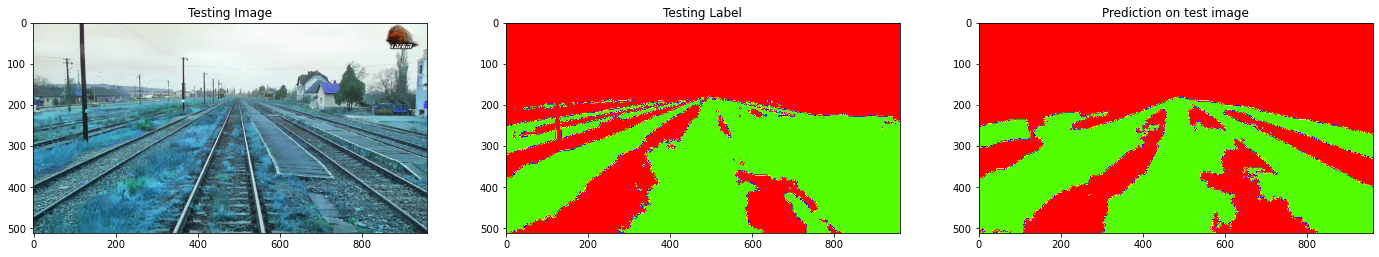

file_name :  rs00230
1/1 [==============================] - 2s 2s/step


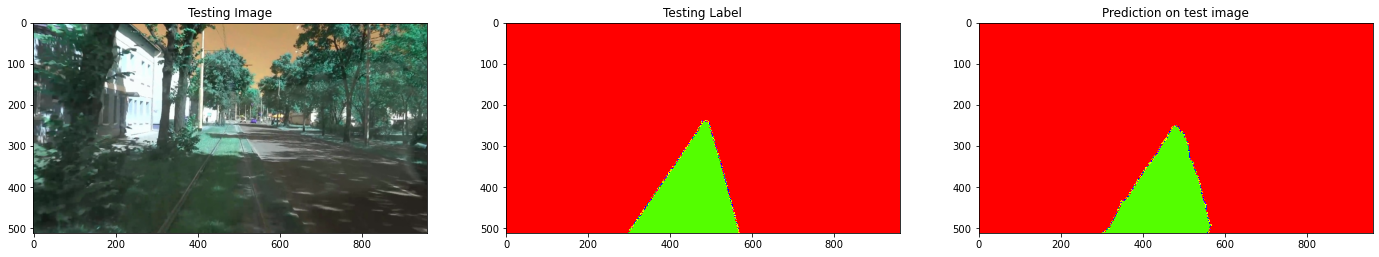

file_name :  rs00039
1/1 [==============================] - 2s 2s/step


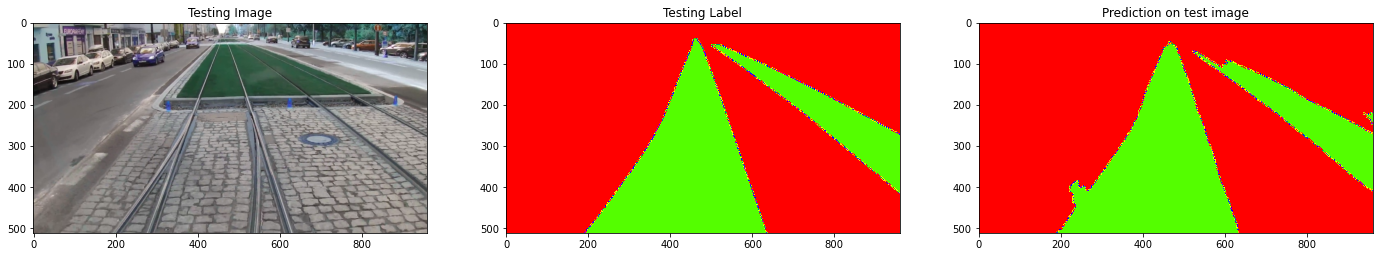

file_name :  rs00588
1/1 [==============================] - 2s 2s/step


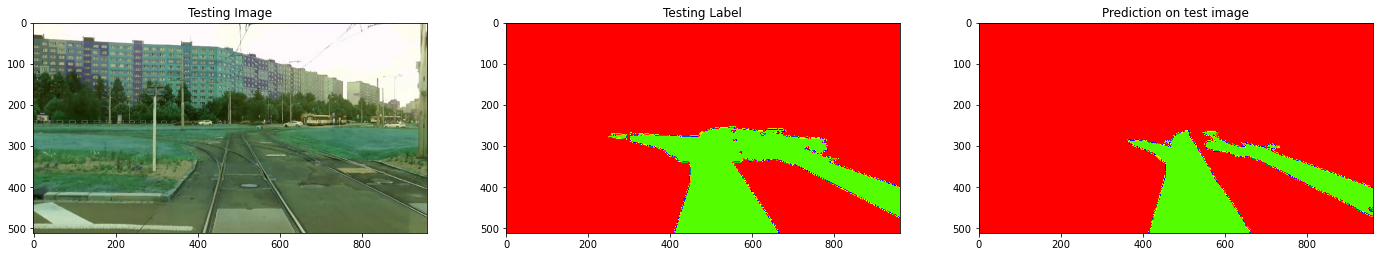

file_name :  rs00320
1/1 [==============================] - 2s 2s/step


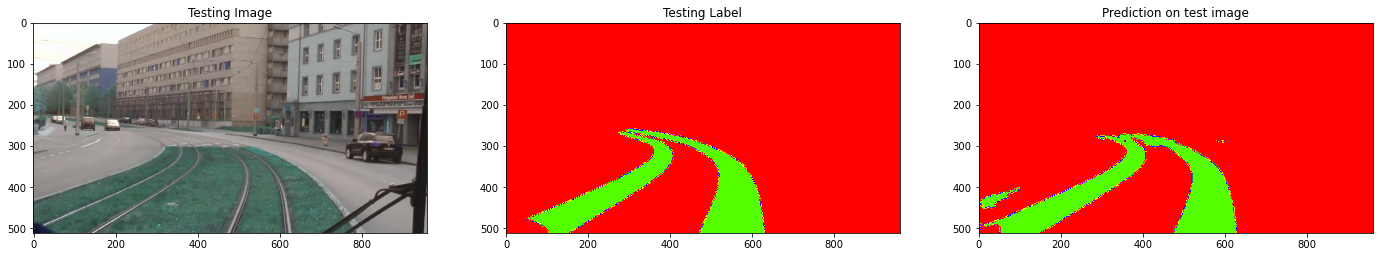

file_name :  rs00140
1/1 [==============================] - 2s 2s/step


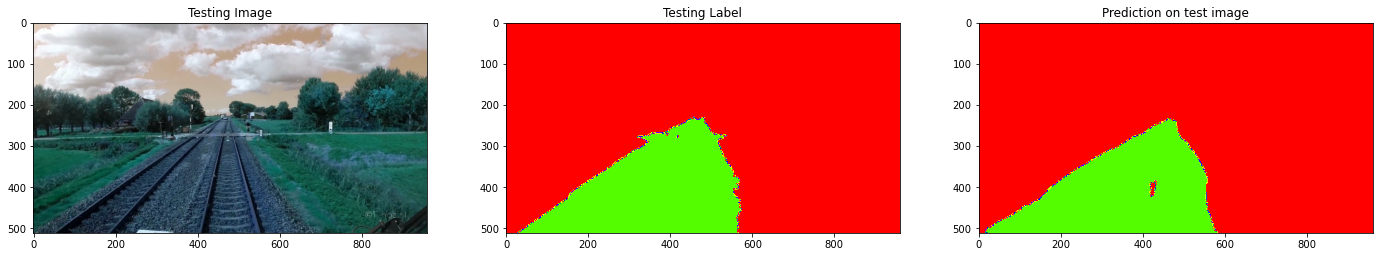

file_name :  rs00600
1/1 [==============================] - 2s 2s/step


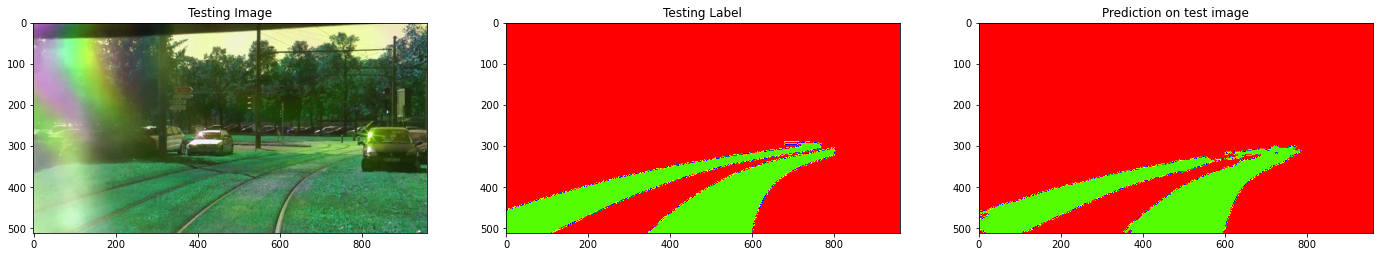

In [18]:
for imgfile in range(len(test_list_veg_track)):
    print("file_name : ",test_list_veg_track[imgfile])
    test_img= cv2.imread(path_images_resized+test_list_veg_track[imgfile]+'.jpg.jpg',1)
    #print('test_image shape',test_img.shape)
    
    ground_truth= cv2.imread(path_masks_resized_track+test_list_veg_track[imgfile]+'.png.png',0)
    #print("ground_truth shape",ground_truth.shape)

    test_img_input=np.expand_dims(test_img, 0) #this is to make (960,512, 1) -> (1, 960, 512, 1)
    #print("ground truth shape expanded", test_img_input.shape)

    prediction = (model_track.predict(test_img_input))
    #print("Prediction shape",prediction_custom.shape)
    my_threshold = 0.8
    predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis
    #print("Prediction_converted_shape",predicted_img_custom.shape)

    plt.figure(figsize=(24, 16))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
    plt.subplot(232)
    plt.title('Testing Label')
    #plt.imshow(ground_truth_custom[:,:,0], cmap='prism')
    plt.imshow(ground_truth[:,:], cmap='prism')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='prism')
    plt.show()

# Load Model Veg

In [20]:
model_veg = load_model("saved_model/veg/veg_model_2000_960x512_Median_Filtered.hdf5", compile=False)

file_name :  rs00275
1/1 [==============================] - 5s 5s/step


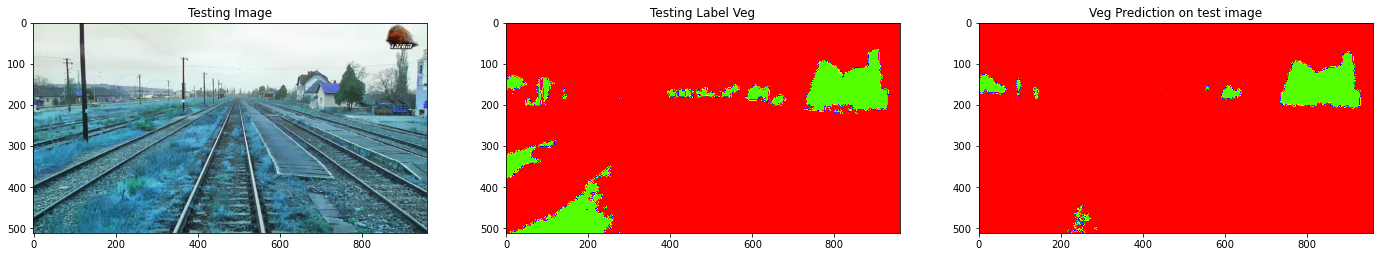

file_name :  rs00230
1/1 [==============================] - 5s 5s/step


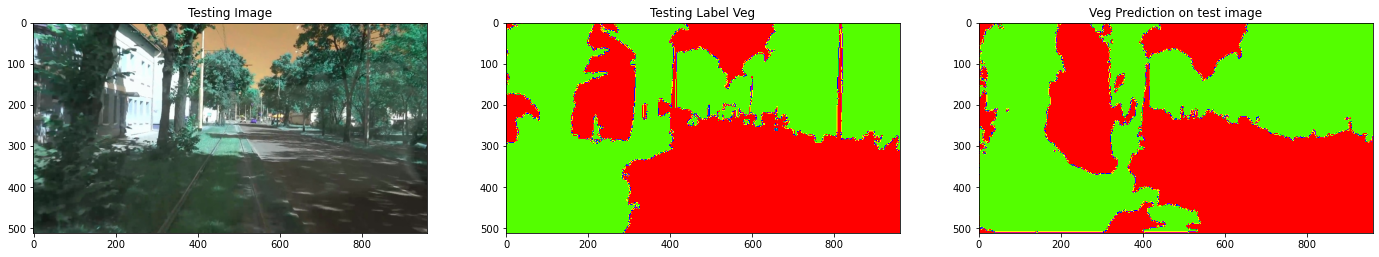

file_name :  rs00039
1/1 [==============================] - 3s 3s/step


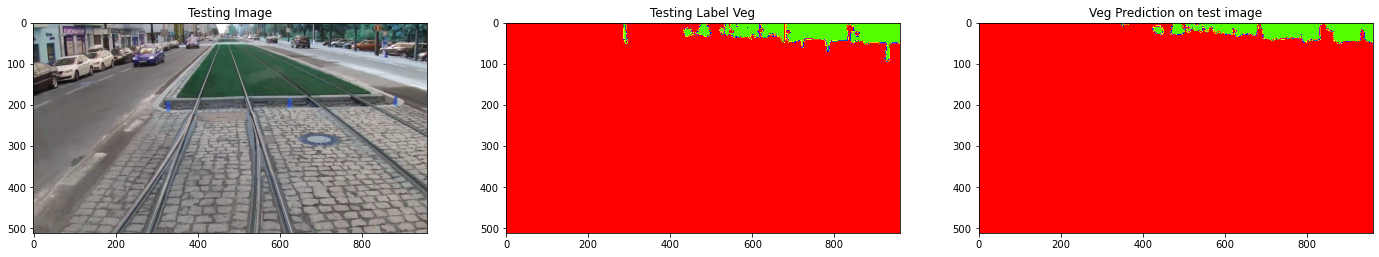

file_name :  rs00588
1/1 [==============================] - 3s 3s/step


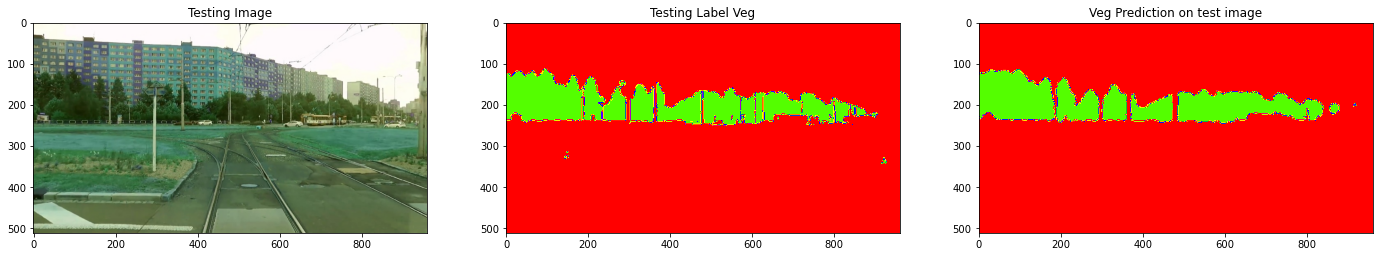

file_name :  rs00320
1/1 [==============================] - 2s 2s/step


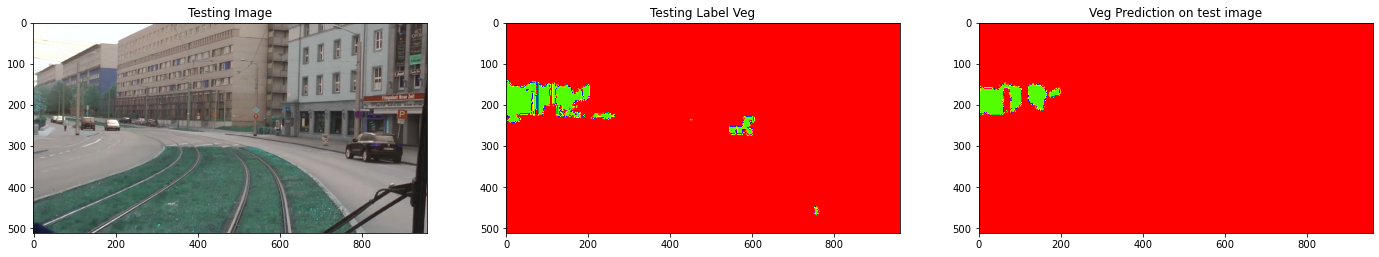

file_name :  rs00140
1/1 [==============================] - 4s 4s/step


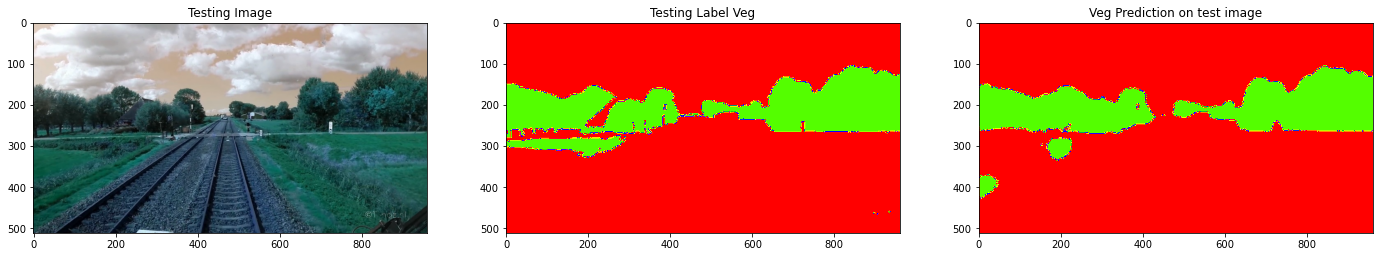

file_name :  rs00600
1/1 [==============================] - 3s 3s/step


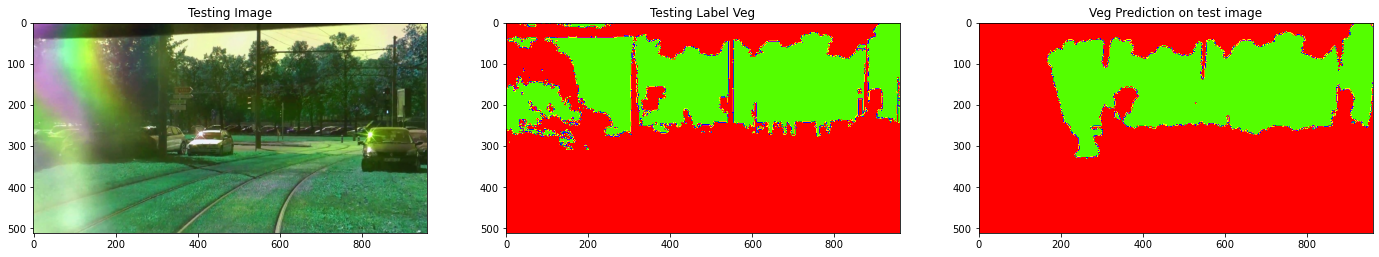

In [21]:
for imgfile in range(len(test_list_veg_track)):
    print("file_name : ",test_list_veg_track[imgfile])
    test_img= cv2.imread(path_images_resized+test_list_veg_track[imgfile]+'.jpg.jpg',1)
    #print('test_image shape',test_img.shape)
    
    ground_truth= cv2.imread(path_masks_resized_veg+test_list_veg_track[imgfile]+'.png.png',0)
    #print("ground_truth shape",ground_truth.shape)

    test_img_input=np.expand_dims(test_img, 0) #this is to make (960,512, 1) -> (1, 960, 512, 1)
    #print("ground truth shape expanded", test_img_input.shape)

    prediction = (model_veg.predict(test_img_input))
    #print("Prediction shape",prediction_custom.shape)
    my_threshold = 0.8
    predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis
    #print("Prediction_converted_shape",predicted_img_custom.shape)

    plt.figure(figsize=(24, 16))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
    plt.subplot(232)
    plt.title('Testing Label Veg')
    #plt.imshow(ground_truth_custom[:,:,0], cmap='prism')
    plt.imshow(ground_truth[:,:], cmap='prism')
    plt.subplot(233)
    plt.title('Veg Prediction on test image')
    plt.imshow(predicted_img, cmap='prism')
    plt.show()

# Function to predict track

In [35]:
def predict_track(test_img_for_track_veg_prediction):
    test_img= test_img_for_track_veg_prediction.copy()
        
    #ground_truth= org_mask_for_track_prediction.copy()
    
    test_img_input=np.expand_dims(test_img, 0) #this is to make (960,512, 1) -> (1, 960, 512, 1)
    #print("ground truth shape expanded", test_img_input.shape)

    prediction = (model_track.predict(test_img_input))
    #print("Prediction shape",prediction_custom.shape)
    my_threshold = 0.8
    predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis
    #print("Prediction_converted_shape",predicted_img_custom.shape)
    predicted_track = predicted_img.copy()
    return predicted_track

# Function to predict veg

In [36]:
def predict_vegetation(test_img_for_track_veg_prediction):
    test_img= test_img_for_track_veg_prediction.copy()
        
    #ground_truth= org_mask_for_veg_prediction.copy()
    
    test_img_input=np.expand_dims(test_img, 0) #this is to make (960,512, 1) -> (1, 960, 512, 1)
    #print("ground truth shape expanded", test_img_input.shape)

    prediction = (model_veg.predict(test_img_input))
    #print("Prediction shape",prediction_custom.shape)
    my_threshold = 0.8
    predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis
    #print("Prediction_converted_shape",predicted_img_custom.shape)
    predicted_veg = predicted_img.copy()
    return predicted_veg

# Post Processing 

## function to dilate

In [25]:
def dilate_mask(predicted_track_to_be_dilated):
    predicted_img=predicted_track_to_be_dilated.copy()
    initial_kernel = np.ones((10,10), np.uint8)
    predicted_img = predicted_img.astype('uint8')
    img_dilation = cv2.dilate(predicted_img, initial_kernel, iterations=1)

    coord = cv2.findNonZero(img_dilation)
    length = len(coord) - 1 
    coord_width = []
    coord_height = []
    for k in range(length):
        coord_width.append(coord[:][k][0][0])
        coord_height.append(coord[:][k][0][1])

    #iter = max(coord_height) - min(coord_height)
    iter = max(coord_width) - min(coord_width)
    highest = min(coord_height)
    highest_1 = min(coord_height) + 1 

    indexwidth = coord_height.index(highest)

    width_mid = coord[:][indexwidth][0][0]
    width_mid = int(width_mid)

    width_mid_1 = width_mid + 1 
    width_mid_1 = int(width_mid)

    for i in range(iter):
        kernel = np.ones((100+i,100+i), np.uint8)
        # condition highesht 
        #if highest > 254: 
        #    highest = 255 
        if highest > 510:  # 960x 512, WxH
            highest = 511 
        else:
            highest = highest + 1
        # condition highest_1 
        #if highest_1 > 245:
        #    highest_1 = 256
        if highest_1 > 501: # 510 -9 
            highest_1 = 512
        else:
            highest_1 = highest_1 + 1  
        # condition width_mid
        #if width_mid < 11:
        #    width_mid = 0
        if width_mid < 11:
            width_mid = 0
        else: 
            width_mid = width_mid - 2 
        # condition width_mid_1 
        #if width_mid_1  > 501:
        #    width_mid_1 = 512
        if width_mid_1  > 949: # 960x512
            width_mid_1 = 960
        else:
            width_mid_1 = width_mid_1 + 2 
        # dilation  
        img_dilation[highest:highest_1, width_mid:width_mid_1] = cv2.dilate(predicted_img[highest:highest_1, width_mid:width_mid_1], kernel, iterations=2)

    return img_dilation



## function to fill the gap 

In [57]:
def fill_zero_function(arr):
    for i in range(len(arr)):
      # Check if the current element has a previous value of 1 at any previous index
      # or any values after it at any forward index as 1
      if any(arr[:i] == 1) and any(arr[i+1:] == 1):
        # If it does not, replace it with 0
        arr[i] = 1
    return arr

## See the the effect of post processing (Dilation + filling) on masks

file_name :  rs03635
1/1 [==============================] - 0s 494ms/step


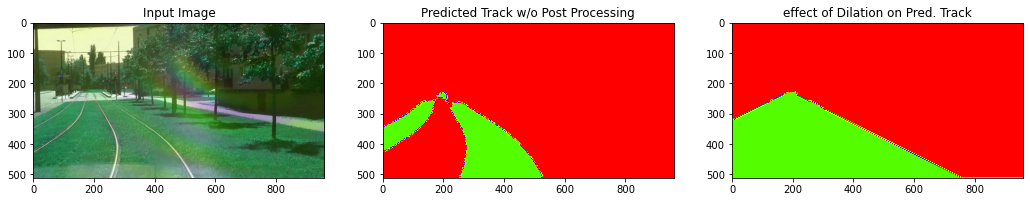

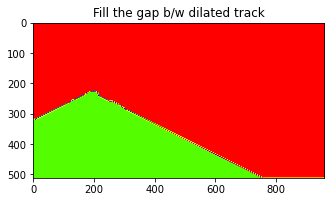

file_name :  rs07754
1/1 [==============================] - 0s 493ms/step


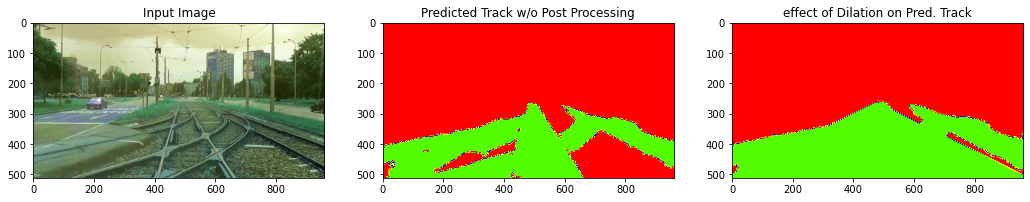

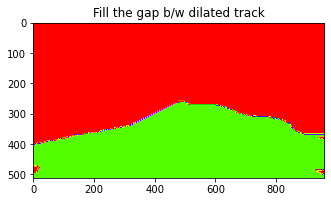

file_name :  rs08334
1/1 [==============================] - 1s 500ms/step


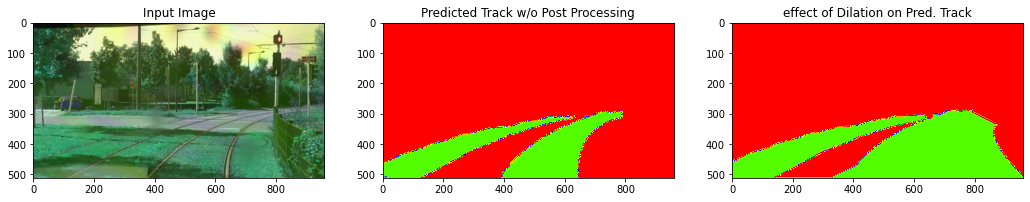

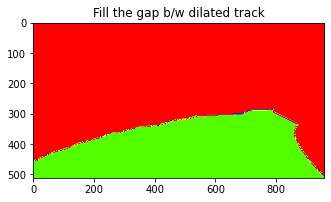

In [74]:
test_track_postpro_list=['rs03635','rs07754','rs08334']
#600,3635,6559,7754,8334

#test_track_postpro_list=['rs00600','rs00275']

for imgfile in range(len(test_track_postpro_list)):
    print("file_name : ", test_track_postpro_list[imgfile])


    testing_img_for_veg_track= cv2.imread(path_images_resized+test_track_postpro_list[imgfile]+'.jpg.jpg',1)
    
    predicted_track_before_post_pro= predict_track(testing_img_for_veg_track)

    track_dilated= dilate_mask(predicted_track_before_post_pro)

    track_dilated_filled = track_dilated.copy()

    for k,val in enumerate(track_dilated_filled):
	    track_dilated_filled[k]=fill_zero_function(val)
    
    plt.figure(figsize=(24, 16))
    plt.subplot(241)
    plt.title('Input Image')
    plt.imshow(testing_img_for_veg_track[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above

    plt.subplot(242)
    plt.title('Predicted Track w/o Post Processing')
    plt.imshow(predicted_track_before_post_pro[:,:], cmap='prism')

    plt.subplot(243)
    plt.title('effect of Dilation on Pred. Track')
    plt.imshow(track_dilated[:,:], cmap='prism')

    plt.figure(figsize=(24, 16))
    plt.subplot(244)
    plt.title('Fill the gap b/w dilated track')
    plt.imshow(track_dilated_filled[:,:], cmap='prism')
    plt.show()

## Function to Post Process the predicted Tracks 

In [29]:
def post_process_tracks(mask_predicted_by_track_model):
    track_mask = mask_predicted_by_track_model.copy()

    track_mask_dilated= dilate_mask(track_mask)

    track_mask_dilated_and_filled= fill_zero_function(track_mask_dilated)
    return track_mask_dilated,track_mask_dilated_and_filled

# multiply predicted veg and predicted track

file_name :  rs00230
1/1 [==============================] - 0s 481ms/step


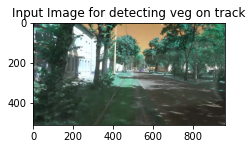

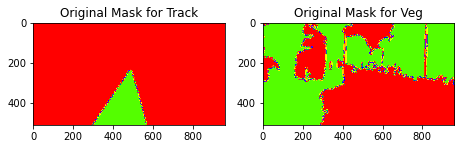

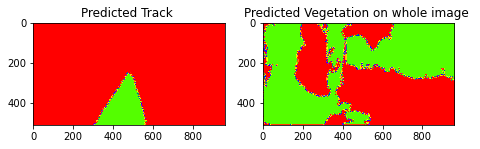

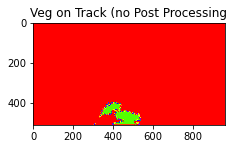

Percentage of veg in ROI:  2.0766194661458335  %
file_name :  rs00275
1/1 [==============================] - 0s 451ms/step


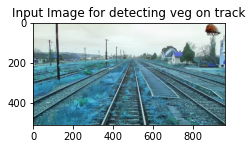

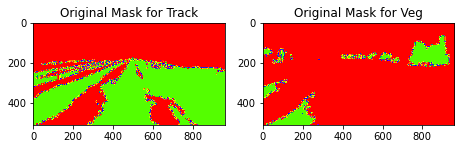

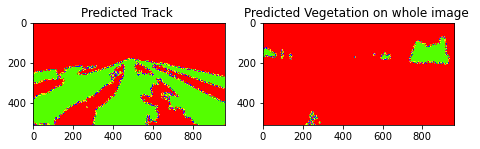

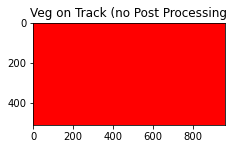

Percentage of veg in ROI:  0.0  %


In [46]:
list_good_veg_roi=['rs00230','rs00275']

for imgfile in range(len(list_good_veg_roi)):
    print("file_name : ",list_good_veg_roi[imgfile])
    
    testing_img_for_veg_track= cv2.imread(path_images_resized+list_good_veg_roi[imgfile]+'.jpg.jpg',1)
    
    
    ground_truth_veg= cv2.imread(path_masks_resized_veg+list_good_veg_roi[imgfile]+'.png.png',0)

    ground_truth_track = cv2.imread(path_masks_resized_track+list_good_veg_roi[imgfile]+'.png.png',0)
    
    
    prediction_for_veg= predict_vegetation(testing_img_for_veg_track)
    prediction_for_track= predict_track(testing_img_for_veg_track)

    multiply_veg_track_nopp= prediction_for_track*prediction_for_veg

    plt.figure(figsize=(24, 16))
    plt.subplot(261)
    plt.title('Input Image for detecting veg on track')
    plt.imshow(testing_img_for_veg_track[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above

    plt.figure(figsize=(24, 16))
    plt.subplot(262)
    plt.title('Original Mask for Track')
    plt.imshow(ground_truth_track[:,:], cmap='prism')

    #plt.figure(figsize=(24, 16))
    plt.subplot(263)
    plt.title('Original Mask for Veg')
    plt.imshow(ground_truth_veg[:,:], cmap='prism')

    plt.figure(figsize=(24, 16))
    plt.subplot(264)
    plt.title('Predicted Track ')
    plt.imshow(prediction_for_track, cmap='prism')

    #plt.figure(figsize=(24, 16))
    plt.subplot(265)
    plt.title('Predicted Vegetation on whole image ')
    plt.imshow(prediction_for_veg, cmap='prism')

    plt.figure(figsize=(24, 16))
    plt.subplot(266)
    plt.title('Veg on Track (no Post Processing')
    plt.imshow(multiply_veg_track_nopp, cmap='prism')
    plt.show()

    #Percentage of veg in roi
    #veg_whole_img= np.count_nonzero(prediction_for_veg==1)    
    pixels_image= multiply_veg_track_nopp.shape[0] * multiply_veg_track_nopp.shape[1]
    veg_roi= np.count_nonzero(multiply_veg_track_nopp==1)
    percent_veg_in_roi= (veg_roi/pixels_image) * 100

    print ("Percentage of veg in ROI: ", percent_veg_in_roi," %")

# multiply veg and post processed mask

file_name :  rs00230
1/1 [==============================] - 3s 3s/step


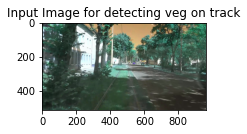

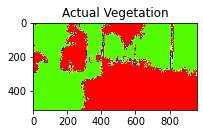

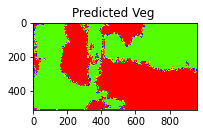

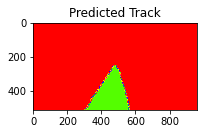

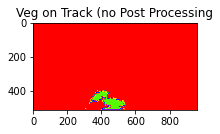

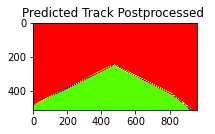

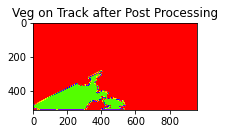

Percentage of veg in ROI without post_processing the tracks:  2.0766194661458335  %
Percentage of veg in ROI without post_processing the tracks:  9.952596028645834  %
file_name :  rs00275
1/1 [==============================] - 3s 3s/step


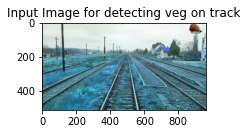

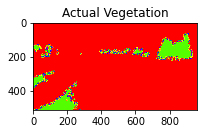

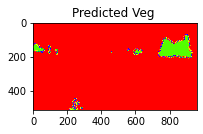

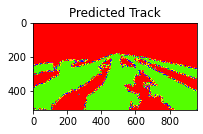

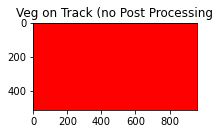

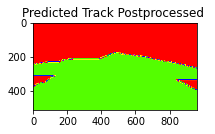

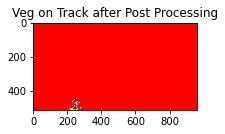

Percentage of veg in ROI without post_processing the tracks:  0.0  %
Percentage of veg in ROI without post_processing the tracks:  0.1824951171875  %
file_name :  rs08334
1/1 [==============================] - 1s 1s/step


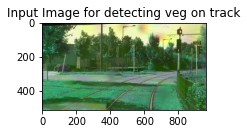

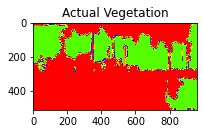

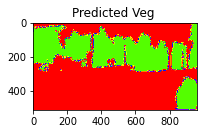

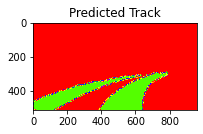

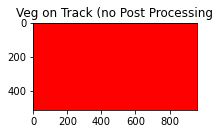

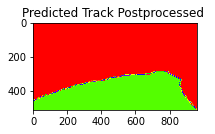

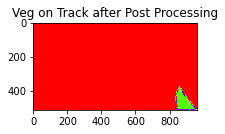

Percentage of veg in ROI without post_processing the tracks:  0.0  %
Percentage of veg in ROI without post_processing the tracks:  1.6868082682291667  %
file_name :  rs01806
1/1 [==============================] - 1s 1s/step


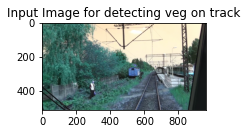

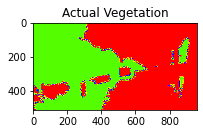

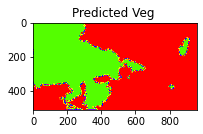

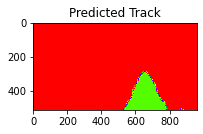

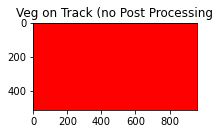

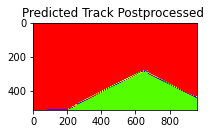

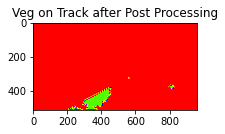

Percentage of veg in ROI without post_processing the tracks:  0.0  %
Percentage of veg in ROI without post_processing the tracks:  2.2635904947916665  %


In [88]:
list_good_veg_roi=['rs00230','rs00275','rs08334','rs01806']

# not extremely good results :- rs00275 becuase predictions are not very great

for imgfile in range(len(list_good_veg_roi)):
    print("file_name : ",list_good_veg_roi[imgfile])
    
    testing_img_for_veg_track= cv2.imread(path_images_resized+list_good_veg_roi[imgfile]+'.jpg.jpg',1)
    
    
    ground_truth_veg= cv2.imread(path_masks_resized_veg+list_good_veg_roi[imgfile]+'.png.png',0)

    ground_truth_track = cv2.imread(path_masks_resized_track+list_good_veg_roi[imgfile]+'.png.png',0)
    
    
    prediction_for_veg= predict_vegetation(testing_img_for_veg_track)
    prediction_for_track= predict_track(testing_img_for_veg_track)

    multiply_veg_track_nopp= prediction_for_track*prediction_for_veg

    # post processing 
    prediction_for_track_dilated = dilate_mask(prediction_for_track)
    prediction_for_track_postprocessed = prediction_for_track_dilated.copy()

    for k,val in enumerate(prediction_for_track_postprocessed):
	    prediction_for_track_postprocessed[k]=fill_zero_function(val)
          
    multiply_veg_track_postprocessed = prediction_for_track_postprocessed * prediction_for_veg[:,:,0]
    

    # plotting to see the image and predictions , dofference after post processing and difference in detection after post processing
    plt.figure(figsize=(24, 16))
    plt.subplot(271)
    plt.title('Input Image for detecting veg on track')
    plt.imshow(testing_img_for_veg_track[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above

    plt.figure(figsize=(24, 16))
    plt.subplot(272)
    plt.title('Actual Vegetation')
    plt.imshow(ground_truth_veg[:,:], cmap='prism')

    plt.figure(figsize=(24, 16))
    plt.subplot(273)
    plt.title('Predicted Veg ')
    plt.imshow(prediction_for_veg, cmap='prism')

    plt.figure(figsize=(24, 16))
    plt.subplot(274)
    plt.title('Predicted Track')
    plt.imshow(prediction_for_track, cmap='prism')

    plt.figure(figsize=(24, 16))
    plt.subplot(275)
    plt.title('Veg on Track (no Post Processing')
    plt.imshow(multiply_veg_track_nopp, cmap='prism')
    plt.show()

    plt.figure(figsize=(24, 16))
    plt.subplot(276)
    plt.title('Predicted Track Postprocessed ')
    plt.imshow(prediction_for_track_postprocessed, cmap='prism')  

   
    plt.figure(figsize=(24, 16))
    plt.subplot(277)
    plt.title('Veg on Track after Post Processing')
    plt.imshow(multiply_veg_track_postprocessed, cmap='prism')
    plt.show()


    #Percentage of veg in roi
    #veg_whole_img= np.count_nonzero(prediction_for_veg==1)    
    pixels_image= multiply_veg_track_nopp.shape[0] * multiply_veg_track_nopp.shape[1]
    veg_roi= np.count_nonzero(multiply_veg_track_nopp==1)
    percent_veg_in_roi= (veg_roi/pixels_image) * 100

    print ("Percentage of veg in ROI without post_processing the tracks: ", percent_veg_in_roi," %")



    pixels_image_postprocessed= multiply_veg_track_postprocessed.shape[0] * multiply_veg_track_postprocessed.shape[1]
    veg_roi_postprocessed= np.count_nonzero(multiply_veg_track_postprocessed==1)
    percent_veg_in_roi_postprocessed= (veg_roi_postprocessed/pixels_image_postprocessed) * 100

    print ("Percentage of veg in ROI without post_processing the tracks: ", percent_veg_in_roi_postprocessed," %")

# Exploring terrain label 

file_name :  rs00320
1/1 [==============================] - 2s 2s/step


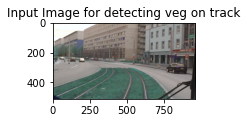

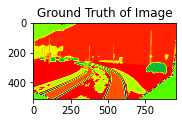

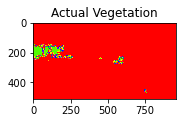

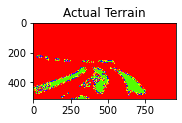

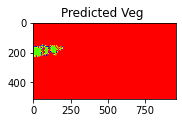

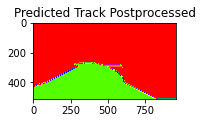

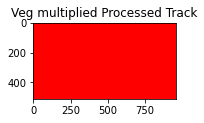

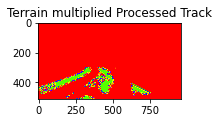

Percentage of veg in ROI with post_processing the tracks:  0.0  %
Percentage of terrain in ROI when multiplied  with post_processing the tracks:  6.141560872395833  %
file_name :  rs00321
1/1 [==============================] - 1s 1s/step


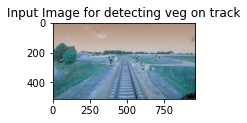

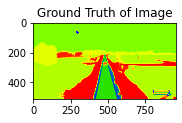

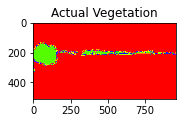

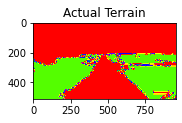

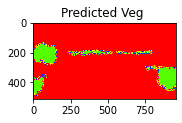

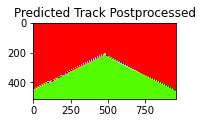

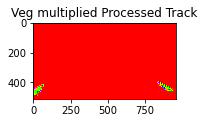

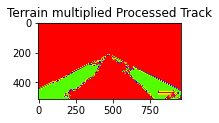

Percentage of veg in ROI with post_processing the tracks:  0.7975260416666666  %
Percentage of terrain in ROI when multiplied  with post_processing the tracks:  15.84716796875  %
file_name :  rs00140
1/1 [==============================] - 1s 1s/step


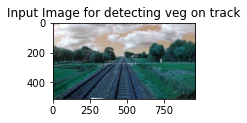

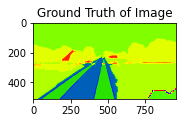

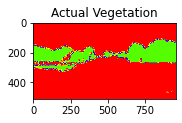

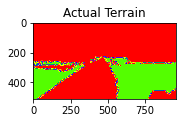

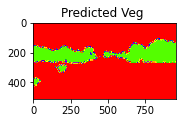

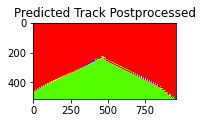

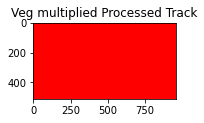

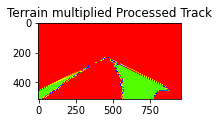

Percentage of veg in ROI with post_processing the tracks:  0.0  %
Percentage of terrain in ROI when multiplied  with post_processing the tracks:  11.6021728515625  %
file_name :  rs00275
1/1 [==============================] - 2s 2s/step


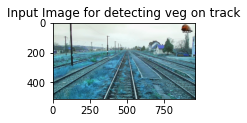

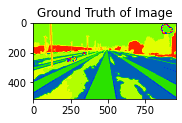

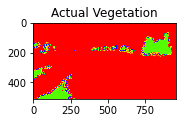

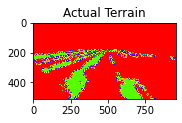

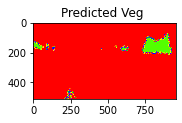

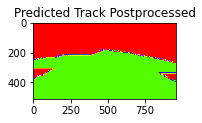

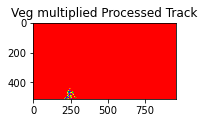

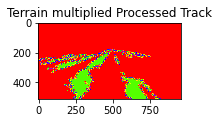

Percentage of veg in ROI with post_processing the tracks:  0.1824951171875  %
Percentage of terrain in ROI when multiplied  with post_processing the tracks:  11.580810546875  %
file_name :  rs05402
1/1 [==============================] - 2s 2s/step


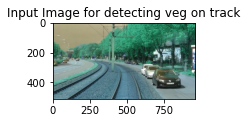

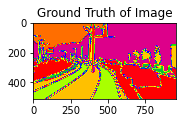

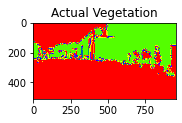

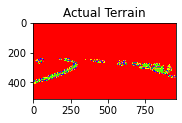

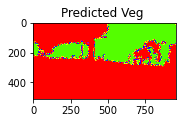

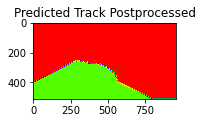

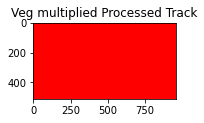

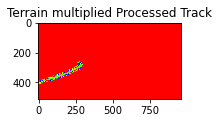

Percentage of veg in ROI with post_processing the tracks:  0.0  %
Percentage of terrain in ROI when multiplied  with post_processing the tracks:  1.2601725260416667  %


In [95]:
list_terrain=['rs00320','rs00321','rs00140','rs00275','rs05402']

# not extremely good results :- rs00275 becuase predictions are not very great

for imgfile in range(len(list_terrain)):
    print("file_name : ",list_terrain[imgfile])
    
    testing_img_for_veg_track= cv2.imread(path_images_resized+list_terrain[imgfile]+'.jpg.jpg',1)
    
    ground_truth_all=cv2.imread(path_masks+list_terrain[imgfile]+'.png',0)

    down_width = 960
    down_height = 512
    down_points = (down_width, down_height)
    ground_truth_all=cv2.medianBlur(ground_truth_all, 3)
    ground_truth_all=cv2.resize(ground_truth_all, down_points, interpolation= cv2.INTER_NEAREST)

    ground_truth_veg= cv2.imread(path_masks_resized_veg+list_terrain[imgfile]+'.png.png',0)

    ground_truth_track = cv2.imread(path_masks_resized_track+list_terrain[imgfile]+'.png.png',0)
    
    # terrain mask
    mask_terrain = ground_truth_all.copy()
    mask_terrain[mask_terrain != terrain]=0
    mask_terrain[mask_terrain== terrain]=1
    
    prediction_for_veg= predict_vegetation(testing_img_for_veg_track)
    prediction_for_track= predict_track(testing_img_for_veg_track)

    #multiply_veg_track_nopp= prediction_for_track*prediction_for_veg

    # post processing 
    prediction_for_track_dilated = dilate_mask(prediction_for_track)
    prediction_for_track_postprocessed = prediction_for_track_dilated.copy()

    for k,val in enumerate(prediction_for_track_postprocessed):
	    prediction_for_track_postprocessed[k]=fill_zero_function(val)
          
    multiply_veg_track_postprocessed = prediction_for_track_postprocessed * prediction_for_veg[:,:,0]

    multiply_track_postprocessed_terrain= prediction_for_track_postprocessed*mask_terrain
    

    # plotting to see the image and predictions , dofference after post processing and difference in detection after post processing
    plt.figure(figsize=(24, 16))
    plt.subplot(281)
    plt.title('Input Image for detecting veg on track')
    plt.imshow(testing_img_for_veg_track[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above

    plt.figure(figsize=(24, 16))
    plt.subplot(282)
    plt.title('Ground Truth of Image')
    plt.imshow(ground_truth_all[:,:], cmap='prism') #the X_train and test has been processed wrt the BACKBONE above

    plt.figure(figsize=(24, 16))
    plt.subplot(283)
    plt.title('Actual Vegetation')
    plt.imshow(ground_truth_veg[:,:], cmap='prism')

    plt.figure(figsize=(24, 16))
    plt.subplot(284)
    plt.title('Actual Terrain')
    plt.imshow(mask_terrain[:,:], cmap='prism')

    plt.figure(figsize=(24, 16))
    plt.subplot(285)
    plt.title('Predicted Veg ')
    plt.imshow(prediction_for_veg, cmap='prism')

    #plt.figure(figsize=(24, 16))
    #plt.subplot(274)
    #plt.title('Predicted Track')
    #plt.imshow(prediction_for_track, cmap='prism')

    #plt.figure(figsize=(24, 16))
    #plt.subplot(275)
    #plt.title('Veg on Track (no Post Processing')
    #plt.imshow(multiply_veg_track_nopp, cmap='prism')
    #plt.show()

    plt.figure(figsize=(24, 16))
    plt.subplot(286)
    plt.title('Predicted Track Postprocessed')
    plt.imshow(prediction_for_track_postprocessed, cmap='prism')  

   
    plt.figure(figsize=(24, 16))
    plt.subplot(287)
    plt.title('Veg multiplied Processed Track')
    plt.imshow(multiply_veg_track_postprocessed, cmap='prism')
    plt.show()

    plt.figure(figsize=(24, 16))
    plt.subplot(288)
    plt.title('Terrain multiplied Processed Track')
    plt.imshow(multiply_track_postprocessed_terrain, cmap='prism')
    plt.show()

    #Percentage of veg in roi
    #veg_whole_img= np.count_nonzero(prediction_for_veg==1)    
    #pixels_image= multiply_veg_track_nopp.shape[0] * multiply_veg_track_nopp.shape[1]
    #veg_roi= np.count_nonzero(multiply_veg_track_nopp==1)
    #percent_veg_in_roi= (veg_roi/pixels_image) * 100

    #print ("Percentage of veg in ROI without post_processing the tracks: ", percent_veg_in_roi," %")


    # percentage of veg* postprocessed track
    pixels_image_postprocessed= multiply_veg_track_postprocessed.shape[0] * multiply_veg_track_postprocessed.shape[1]
    veg_roi_postprocessed= np.count_nonzero(multiply_veg_track_postprocessed==1)
    percent_veg_in_roi_postprocessed= (veg_roi_postprocessed/pixels_image_postprocessed) * 100

    print ("Percentage of veg in ROI with post_processing the tracks: ", percent_veg_in_roi_postprocessed," %")

    # percentage of terrain * postprocessed track
    pixels_image_pptrack_terrain= multiply_track_postprocessed_terrain.shape[0] * multiply_track_postprocessed_terrain.shape[1]
    terrain_roi_postprocessed= np.count_nonzero(multiply_track_postprocessed_terrain==1)
    percent_terrain_in_roi_postprocessed= (terrain_roi_postprocessed/pixels_image_pptrack_terrain) * 100

    print ("Percentage of terrain in ROI when multiplied  with post_processing the tracks: ", percent_terrain_in_roi_postprocessed," %")

# Appendix 

In [26]:
def post_process(file):
	image= cv2.imread(path_images_resized+file+'.jpg.jpg',1)
	org_mask=cv2.imread(path_masks+file+'.png',0)
	final_mask = cv2.imread(path_masks_resized_track+file+'.png.png',0)

	down_width = 960
	down_height = 512
	down_points = (down_width, down_height)
	org_mask=cv2.medianBlur(org_mask, 3)
	org_mask=cv2.resize(org_mask, down_points, interpolation= cv2.INTER_NEAREST)
	
	plt.imshow(image)
	plt.title('Image original resized')
	plt.show()

	plt.imshow(org_mask,cmap='prism')
	plt.title('mask original resized')
	plt.show()
	

	plt.imshow(final_mask,cmap='jet')
	plt.title('mask_track')
	plt.show()
	

		
	mask_veg = org_mask.copy()
	mask_veg[mask_veg != veg]=0
	mask_veg[mask_veg== veg]=1
	
	mask_terrain = org_mask.copy()
	mask_terrain[mask_terrain != terrain]=0
	mask_terrain[mask_terrain== terrain]=1



	track_mask_dilated= dilate_mask(final_mask)
	
	#fill_gap_track_dilated= track_mask_dilated.copy()
	#for k,val in enumerate(fill_gap_track_dilated):
	#	fill_gap_track_dilated[k]=forward_fill_ifsame(val)

	fill_zero= track_mask_dilated.copy()
	for k,val in enumerate(fill_zero):
		fill_zero[k]=fill_zero_function(val)
	
	veg_dilated_track= track_mask_dilated*mask_veg
	
	#veg_dilated_track_filled=fill_gap_track_dilated*mask_veg
	veg_dilated_track_filled=fill_zero*mask_veg

	# veg_terrain_track multiplied without preprocessing
	terrain_trackdilatedfilled=track_mask_dilated * mask_terrain
	
	plt.imshow(track_mask_dilated,cmap='jet')
	plt.title('mask_track_dilated')
	plt.show()

		
	plt.imshow(fill_zero,cmap='jet')
	plt.title('filled_gap_zero_in dilated track mask')
	plt.show()
	
	
	plt.imshow(mask_veg,cmap='prism')
	plt.title('mask_veg')
	plt.show()

	plt.imshow(mask_terrain,cmap='prism')
	plt.title('mask_terrain')
	plt.show()
	
	plt.imshow(veg_dilated_track,cmap='prism')
	plt.title('Veg_multiplied_track_with_dilation')
	plt.show()
	
	plt.imshow(veg_dilated_track_filled,cmap='prism')
	plt.title('Veg_multiplied_track_with_dilation_and_filling')
	plt.show()

	plt.imshow(terrain_trackdilatedfilled,cmap='prism')
	plt.title('terrain_track (dilated and filled) multiplied')
	plt.show()

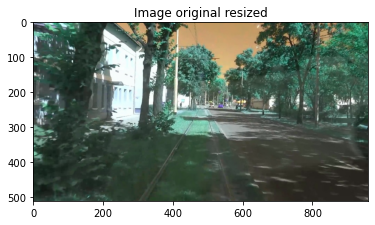

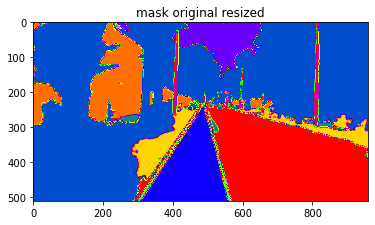

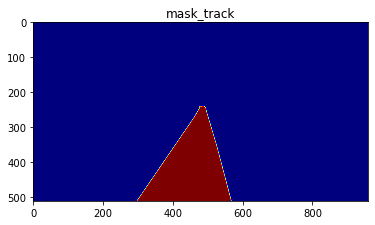

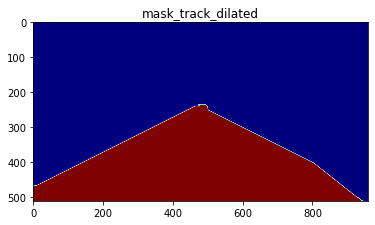

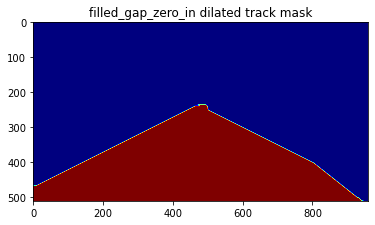

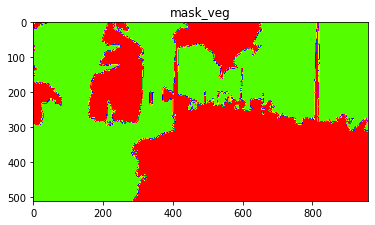

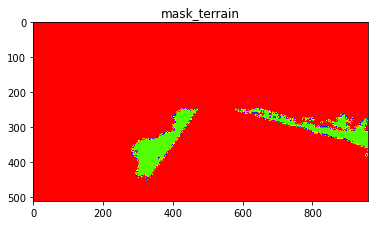

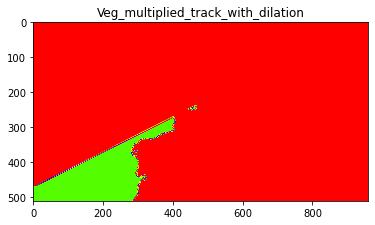

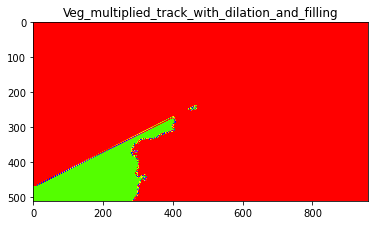

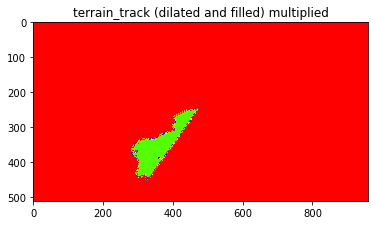

In [27]:
file='rs00230'
post_process(file)